/var/folders/02/1czf1gxd31x7ld0967mhs8sw0000gn/T/ipykernel_12556/382835242.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Text(0.5, 1.0, 'Light Curve for CV Eclipsed Star')

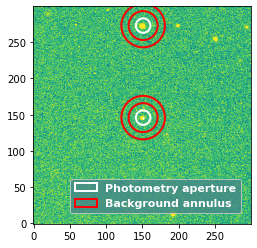

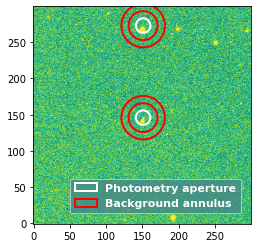

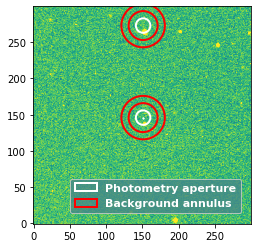

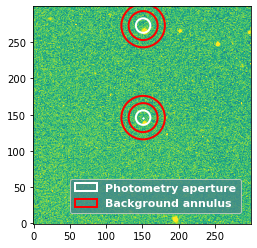

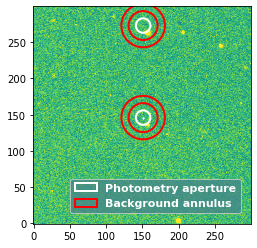

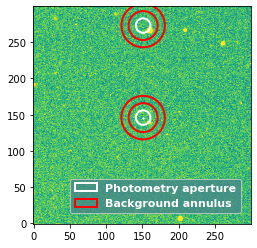

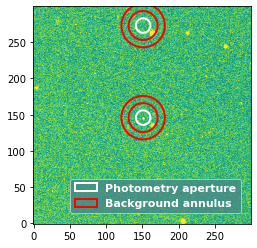

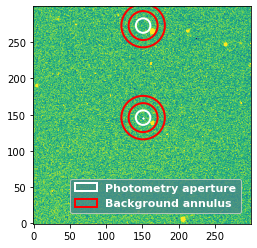

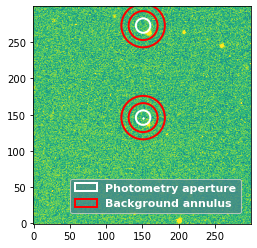

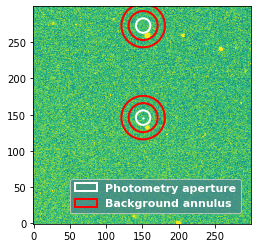

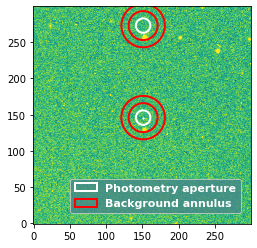

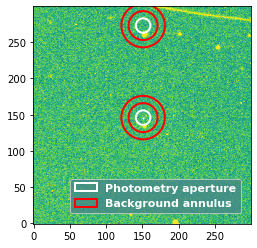

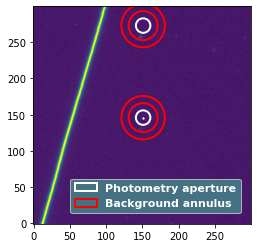

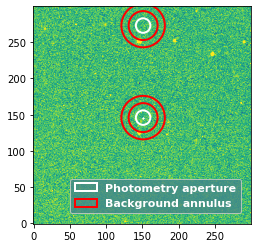

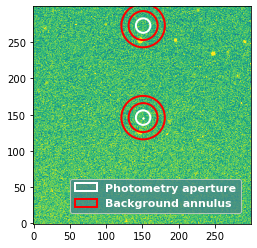

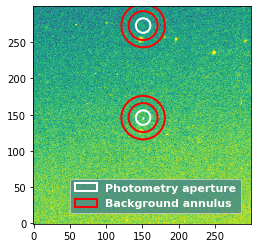

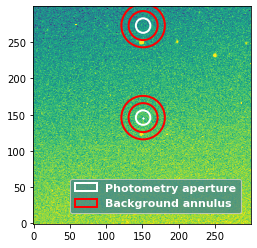

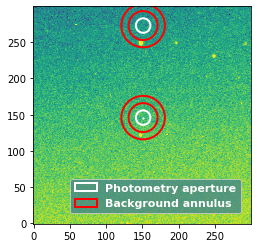

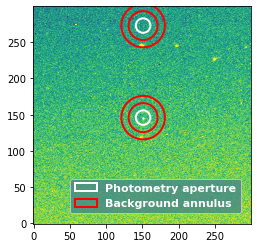

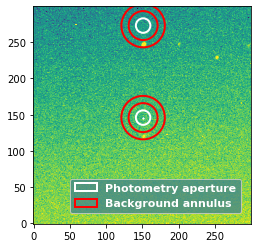

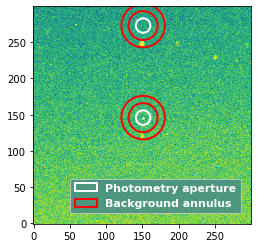

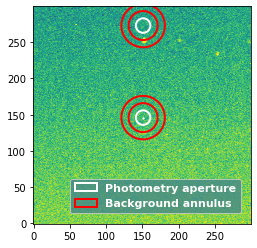

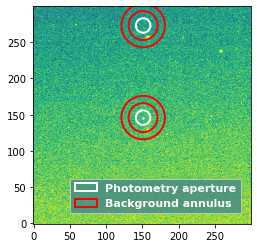

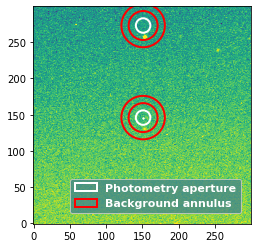

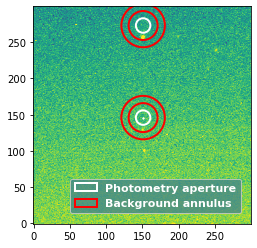

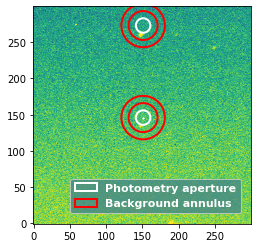

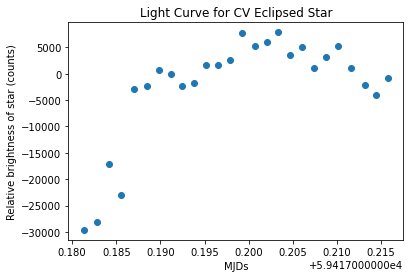

In [47]:
#Code Astro Group 36 Project
#Creating a stellar lightcurve

"""
Input: fits image, stellar coordinates
Output: lightcurve
"""

#Importing all necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from photutils.aperture import SkyCircularAperture
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.time import Time
from astropy.wcs import WCS
from photutils.aperture import CircularAperture, CircularAnnulus, ApertureStats, aperture_photometry
from astropy.visualization import simple_norm
import glob
#from astroquery.astrometry_net import AstrometryNet

#Inputs: 
#radec = ['13:00:34.3262', '17:18:06.706'] # sexegesimal
#refradec = ['13:22:36.0723', '86:17:49.036'] #sexegesimal
radec = [195.143026, 17.30186275] # degrees
refradec = [200.6503103, 86.29695441] # degrees
pixels = [1529, 1524] #[4785, 3188] #pixel location of the target star
refpixels = [1529, 1651] #[4705, 3216] #pixel location of the reference star
ap_size = 10 # aperture size, in pixels, 5
an_small = 20 # size of inner ring of annulus, in pixels, 10
an_large = 30 #size of outer ring of annulus, in pixels, 15
imsz = 150 # number of pixels from the middle to the edge of the image, in x and y

plt.close('all')

def star_counts(pixels, data):
    #Getting the mean background 
    aperture = CircularAperture(pixels, r=ap_size)
    annulus_aperture = CircularAnnulus(pixels, r_in=an_small, r_out=an_large)
    aperstats = ApertureStats(data, annulus_aperture)
    bkg_mean = aperstats.mean

    #Getting the aperture area
    phot_table = aperture_photometry(data, aperture)
    aperture_area = aperture.area_overlap(data)

    #Getting the photometry within the aperture
    total_bkg = bkg_mean * aperture_area
    phot_bkgsub = phot_table['aperture_sum'] - total_bkg
    return phot_bkgsub, aperture, annulus_aperture #total counts within the aperture, aperture object, annulus_object


files = sorted(glob.glob('/Users/emilywhittaker/AnacondaProjects/CodeAstro/group_project/Small/*.fit'))
relstars_lst = []
mjds_lst = []
for i in range(len(files)):
    fitsfile = files[i]
    #print(fitsfile)

    # importing the fits file and extracting data
    image_file = get_pkg_data_filename(fitsfile)
    image_data = fits.getdata(image_file, header=True)
    data = image_data[0]
    hdr = image_data[1]

    #Extracting the time from the image header and converting to MJD
    time = hdr['DATE-OBS']
    #print(time)
    t = Time(time, format='isot', scale='utc')

    mjds_lst.append(t.mjd)
    
    #Converting the input coordinates to pixel coordinates in the image
    w = WCS(hdr)
    xy = w.wcs_world2pix(radec[0], radec[1], 1) # maybe try skycoord to pixel
    ref_xy = w.wcs_world2pix(refradec[0], refradec[1], 1) # maybe try skycoord to pixel
    pixels = xy
    refpixels = ref_xy

    #Getting more precise pixel location by measuring brightness
    """
    boxsz = 20 #size of the test box, in pixels
    small_data = data[limx-boxsz:limx+boxsz, limy-imsz:limy+boxsz]
    """
    #Shrinking the data to a reasonable size
    limx = data.shape[0]//2
    limy = data.shape[1]//2
    small_data = data[limx-imsz:limx+imsz, limy-imsz:limy+imsz]
    small_pixels = [pixels[0]-limy+imsz, pixels[1]-limx+imsz]
    small_refpixels = [refpixels[0]-limy+imsz, refpixels[1]-limx+imsz]
    
    #Checking that the location in pixels is correct by plotting
    norm = simple_norm(small_data, 'sqrt', percent=99)
    plt.figure()
    plt.imshow(small_data, norm=norm)
    plt.scatter(small_pixels[0], small_pixels[1], color='w', marker='*', s=2)
    plt.gca().invert_yaxis()

    #Getting the instrument counts for the star and the reference star
    star_cts, star_aperture, star_annulus = star_counts(small_pixels, small_data)
    refstar_cts, refstar_aperture, refstar_annulus = star_counts(small_refpixels, small_data)

    #Relative counts (star - reference star)
    rel_star_cts = star_cts - refstar_cts
    relstars_lst.append(rel_star_cts[0])

    #Plotting the annulus and aperture as a check
    ap_patches = star_aperture.plot(color='white', lw=2,
                            label='Photometry aperture')
    ann_patches = star_annulus.plot(color='red', lw=2,
                                        label='Background annulus')
    handles = (ap_patches[0], ann_patches[0])
    plt.legend(loc=(0.17, 0.05), facecolor='#458989', labelcolor='white',
            handles=handles, prop={'weight': 'bold', 'size': 11})

    ref_ap_patches = refstar_aperture.plot(color='white', lw=2,
                            label='Photometry aperture')
    ref_ann_patches = refstar_annulus.plot(color='red', lw=2,
                                        label='Background annulus')

    #Flux = Gain * Counts / Exptime 

#Plotting the light curve
relstars = np.array(relstars_lst)
mjds = np.array(mjds_lst)

plt.figure()
plt.scatter(mjds, relstars)
plt.xlabel("MJDs")
plt.ylabel("Relative brightness of star (counts)")
plt.title("Light Curve for CV Eclipsed Star")
